# Goal: Find drivers of upsets in chess games and create a model to predict upsets 

* Upset is defined as a player with a lower rating winning a game agenst a player with a higher rating
* Model should make a predictions after having 'interviewed' each player as to thier intended opening as white and what defence they intend to use against a given opening as black

### Initial Thoughts

<br>

* Going into this project I am of two minds.

<br>

**First**
* Chess is a skill based game with no random elements (except assigning first move). 
* Because of this the player with the highest level of skill will win any game not determined by variation in player performance. 
* Because of this a given game will be won by the player with the highest level of skill a large majority of the time. * If this is true conditions underwhich variation in performance is the highest should result in the highest likelyhood of an upset.

<br>

**Second**
* It may also be the case that more skilled players are able to maintain consistancy better than less skilled players under conditions that would increased variation in thier performance.
* If this is true, those conditions may make upsets less likely as the variance would have a grater effect on the the less skilled player than on the more skilled player.

<br>

**Conclution**
* Though these two schools of thought may point at differing conclutions, both seem grounded in reason and I am eager to see what the data can tell us

### Initial Hypothisese About Drivers

* There will be few instances of upsets, possibly leading to an imbalanced data set
* As ratings for both players increase, the likelyhood of an upset will decrease 
* As the margin between player ratings increase the likelyhood of an upsets will decrease
* Shorter time incraments will increase the likelyhood of an upset
* Unranked games will have a higher likelyhood of an upset than ranked games
* Games where the higher rated player is moving the white pieces (gaining first move advantage) will have a decreased likelyhood of of an upset
* Some opening/defense stratagies may be more or less prone to upsets
* openings/defences that are more popular or perfered by higher rated players may be more/less prone to upset

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

import re

import wrangle as w

# Acquire

* Data acquired from Kaggle at https://www.kaggle.com/datasnaek/chess
* It contained 20,058 rows and 9 columns before cleaning

# Prepare

**Data was very clean initially, I performed the following steps to insure that is was ready for exploration:**
* Removed columns that did not contain useful information\* 
* Renamed columns to premote readability\*
* Checked for nulls in the data (there were none)
* Checked that column data types were ppropriate
* Removed white space from values in object columns
* There were no rows lost during preperation
* Added Target column 'upset' indicating weather the lower rated player won the game
* Added additional features to investigate (columns that could be calculated one row at a time)*
* Split data into train, validate and test (approx. 60/20/20), stritifying on 'upset'
* Added additional features to investigate (columns that requiered an aggregate calculation by column)
* aggregat calculations were performed on train data
* resulting calculations were then applied to create columns in train, validate, and test data.

In [35]:
df = w.wrangle_chess_data(reprep = True)
train, validate, test = w.split_my_data(df)
train, validate, test = w.fe_post_split(train, validate, test)
train.columns

Index(['rated', 'turns', 'ended_as', 'winning_pieces', 'time_code',
       'white_rating', 'black_rating', 'opening_code', 'opening_name', 'upset',
       'rating_dif', 'game_rating', 'lower_rated_white', 'time_block',
       'time_minutes'],
      dtype='object')

In [47]:
train['opening_code_pop'] = train['opening_code'].apply(lambda value : train.opening_code.value_counts()[value]/len(train))
train['opening_name_pop'] = train['opening_name'].apply(lambda value : train.opening_name.value_counts()[value]/len(train))


In [48]:
train.head(10)

,rated,turns,ended_as,winning_pieces,time_code,white_rating,black_rating,opening_code,opening_name,upset,rating_dif,game_rating,lower_rated_white,time_block,time_minutes,opening_code_pop,opening_name_pop
3596,True,94,resign,white,10+0,1393,1404,C41,Philidor Defense #2,True,11,1398,True,10,10.000000,0.035167,0.009526
5159,False,146,mate,black,40+2,1505,1743,C53,Italian Game: Classical Variation #2,False,238,1624,True,40,41.004432,0.004006,0.001068
14725,True,82,mate,black,10+0,1255,1626,B21,Sicilian Defense: Smith-Morra Gambit #2,False,371,1440,True,10,10.000000,0.012553,0.005876
13305,True,150,mate,black,5+5,1540,1536,D00,Queen's Pawn Game #3,True,4,1538,False,5,7.511081,0.036592,0.002849
14307,True,26,mate,black,10+0,1545,1890,C20,King's Pawn Game: Mengarini's Opening,False,345,1717,True,10,10.000000,0.033387,0.000890
11924,True,57,resign,black,10+0,1686,1723,A40,Modern Defense,False,37,1704,True,10,10.000000,0.031962,0.008725
5684,True,69,resign,white,5+5,1812,1811,A00,Polish Opening: Czech Defense,False,1,1811,False,5,7.511081,0.049234,0.000178
5873,True,102,mate,black,10+0,1331,1695,C41,Philidor Defense #3,False,364,1513,True,10,10.000000,0.035167,0.009526
14789,True,68,outoftime,black,10+0,1273,1330,B00,Nimzowitsch Defense: Kennedy Variation | Link...,False,57,1301,True,10,10.000000,0.030004,0.003027
14557,True,135,mate,white,7+2,1746,1256,A00,Polish Opening,False,490,1501,False,7,8.004432,0.049234,0.002582


In [ ]:
train.head()

In [33]:
opening_list = train.opening_code.to_list()
opening_name_list = train.opening_name.to_list()

In [4]:
average_moves_per_game = train.turns.mean()
int(average_moves_per_game)

60

In [5]:
median_moves_per_game = train.turns.median()
median_moves_per_game

55.0

In [6]:
train.time_code.value_counts().head(20)

10+0     4342
15+0      721
15+15     489
5+5       405
5+8       383
10+5      343
8+0       339
15+10     263
20+0      248
30+0      204
10+10     184
15+5      176
7+2       135
10+2      111
30+30      88
25+0       85
5+10       83
10+3       80
10+8       69
45+45      62
Name: time_code, dtype: int64

In [7]:
reg = r'\+'

string = '10+5'

time = re.sub(reg, ' ', string)
time = time.split(' ')

((int(time[0]) * 60) + (int(time[1]) * (average_moves_per_game/2)))/60

12.511080692070275

In [8]:
10 * 60

600

In [9]:
5 * 30

150

In [10]:
750/60

12.5

### Examine Object Variables

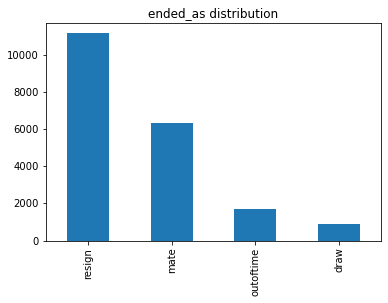

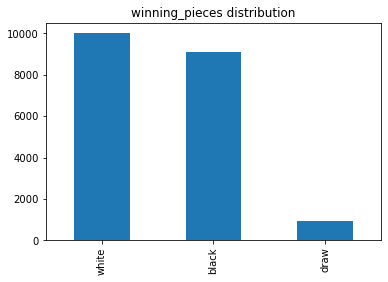

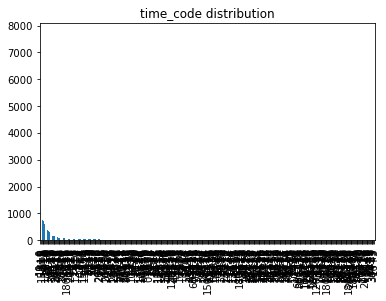

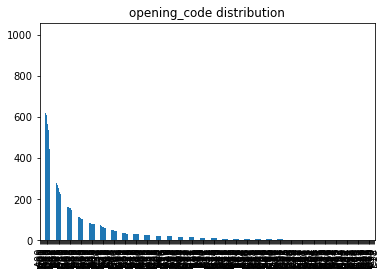

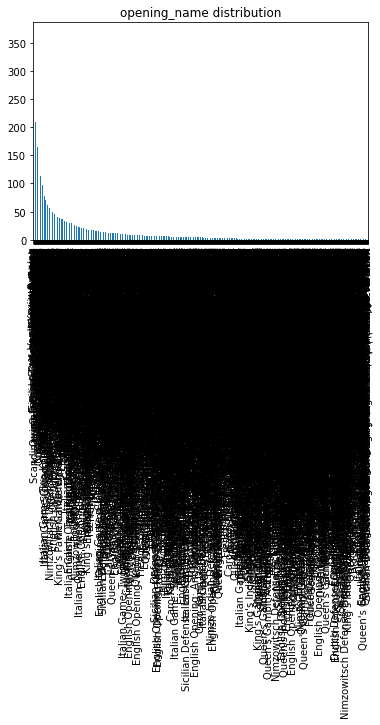

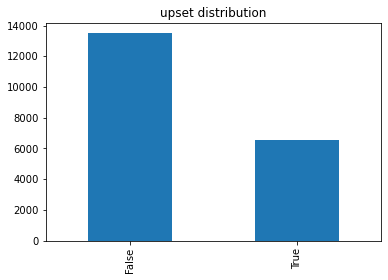

In [11]:
# distribution of the data
columns = ['ended_as', 'winning_pieces', 
           'time_code', 'opening_code', 
           'opening_name', 'upset']

for col in columns:
    
    df[col].value_counts().plot(kind='bar', title = f"{col} distribution")
    
    plt.show()

### Takeaways

* Resignations usually happen when mate is enevitable I see no reason to seperate the two
* I wonder if running out of time has an effect on upsets? 
* White does have an advantage, though it is much smaller than I thought it would be, at about 10% higher number of wins than black
* time_code, opening_code, and opening_name, have too many values to sort through at the moment and will have to be binned or pruened
* upsets represent about 1/3 or the data, which is higher than I thought it would be

### Examine Quantitative Variables

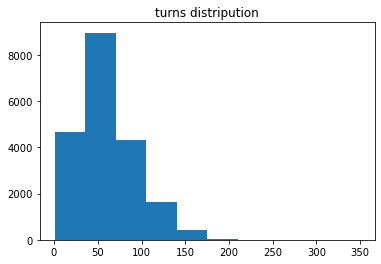

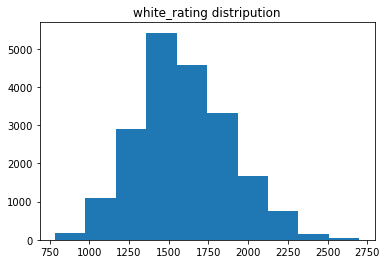

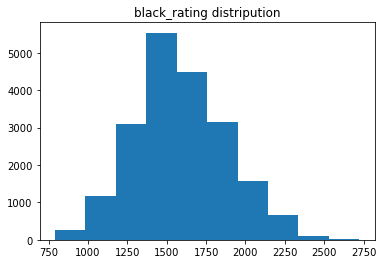

In [12]:
# distribution of the data
cols = ['turns', 'white_rating', 'black_rating']

for col in cols:
    plt.hist(df[col])
    plt.title(col+' distripution')
    plt.show()

### Takeaways

* Turns is slightly right skewed 
* Black and white rating distributions are pretty normally distributed and are nearly if not entierly identical

In [13]:
df.time_code.value_counts()

10+0     7721
15+0     1311
15+15     850
5+5       738
5+8       697
         ... 
20+9        1
90+8        1
35+35       1
30+45       1
16+3        1
Name: time_code, Length: 400, dtype: int64

### I'm goint to try to prune the object columns by removing the values that do not have a significant represintation I an setting my trial cut off point at 50 or more occurrences 

In [14]:
df.to_csv('games_preped.csv')
df = pd.read_csv('games_preped.csv')

In [15]:
df.drop(columns=['Unnamed: 0'], inplace = True)

In [16]:
df.head()

,rated,turns,ended_as,winning_pieces,time_code,white_rating,black_rating,opening_code,opening_name,upset,rating_dif,game_rating,lower_rated_white,time_block
0,False,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,False,309,1345,False,15
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,True,61,1291,False,5
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,True,4,1498,True,5
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,True,15,1446,True,20
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,False,54,1496,False,30


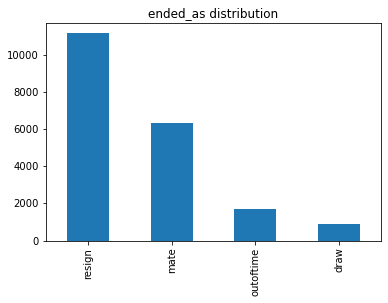

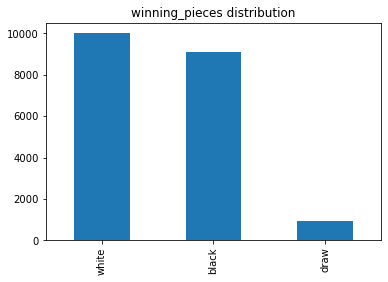

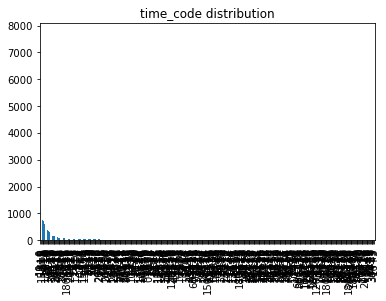

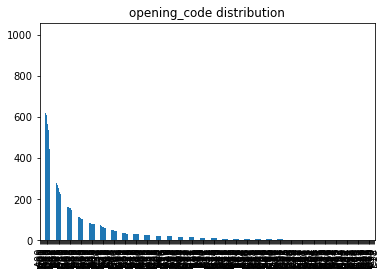

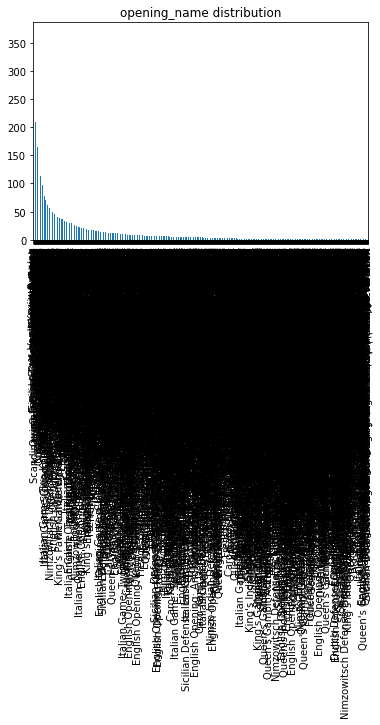

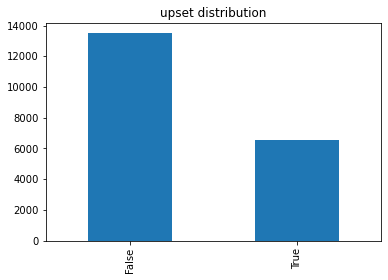

In [17]:
# distribution of the data
columns = ['ended_as', 'winning_pieces', 
           'time_code', 'opening_code', 
           'opening_name', 'upset']

for col in columns:
    
    df[col].value_counts().plot(kind='bar', title = f"{col} distribution")
    
    plt.show()

In [18]:
from wrangle import wrangle_chess_data

In [19]:
df = wrangle_chess_data()
df.head()

,rated,turns,ended_as,winning_pieces,time_code,white_rating,black_rating,opening_code,opening_name,upset,rating_dif,game_rating,lower_rated_white,time_block
0,False,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,False,309,1345,False,15
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,True,61,1291,False,5
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,True,4,1498,True,5
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,True,15,1446,True,20
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,False,54,1496,False,30


In [20]:
df['rating_diff'] = abs(df.white_rating-df.black_rating)
df.head()

,rated,turns,ended_as,winning_pieces,time_code,white_rating,black_rating,opening_code,opening_name,upset,rating_dif,game_rating,lower_rated_white,time_block,rating_diff
0,False,13,outoftime,white,15+2,1500,1191,D10,Slav Defense: Exchange Variation,False,309,1345,False,15,309
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,True,61,1291,False,5,61
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,True,4,1498,True,5,4
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,True,15,1446,True,20,15
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,False,54,1496,False,30,54


# removing under 1200 rated players to eliminate new/novice players

In [21]:
df = df[(df.white_rating >= 1200) &(df.black_rating >= 1200)]

In [22]:
df['average_rating'] = (df.white_rating + df.black_rating) / 2

In [23]:
df

,rated,turns,ended_as,winning_pieces,time_code,white_rating,black_rating,opening_code,opening_name,upset,rating_dif,game_rating,lower_rated_white,time_block,rating_diff,average_rating
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,True,61,1291,False,5,61,1291.5
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,True,4,1498,True,5,4,1498.0
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,True,15,1446,True,20,15,1446.5
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,False,54,1496,False,30,54,1496.0
6,True,33,resign,white,10+0,1520,1423,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,False,97,1471,False,10,97,1471.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20052,True,37,resign,white,10+10,1219,1250,A40,English Defense,True,31,1234,True,10,31,1234.5
20053,True,24,resign,white,10+10,1691,1220,A80,Dutch Defense,False,471,1455,False,10,471,1455.5
20055,True,35,mate,white,10+0,1219,1286,D00,Queen's Pawn Game: Mason Attack,True,67,1252,True,10,67,1252.5
20056,True,109,resign,white,10+0,1360,1227,B07,Pirc Defense,False,133,1293,False,10,133,1293.5


In [24]:
df['upset'] = (((df.white_rating > df.black_rating) & (df.winning_pieces == 'black')) |
               ((df.white_rating < df.black_rating) & (df.winning_pieces == 'white')))

In [25]:
df

,rated,turns,ended_as,winning_pieces,time_code,white_rating,black_rating,opening_code,opening_name,upset,rating_dif,game_rating,lower_rated_white,time_block,rating_diff,average_rating
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,True,61,1291,False,5,61,1291.5
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,True,4,1498,True,5,4,1498.0
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,True,15,1446,True,20,15,1446.5
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,False,54,1496,False,30,54,1496.0
6,True,33,resign,white,10+0,1520,1423,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,False,97,1471,False,10,97,1471.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20052,True,37,resign,white,10+10,1219,1250,A40,English Defense,True,31,1234,True,10,31,1234.5
20053,True,24,resign,white,10+10,1691,1220,A80,Dutch Defense,False,471,1455,False,10,471,1455.5
20055,True,35,mate,white,10+0,1219,1286,D00,Queen's Pawn Game: Mason Attack,True,67,1252,True,10,67,1252.5
20056,True,109,resign,white,10+0,1360,1227,B07,Pirc Defense,False,133,1293,False,10,133,1293.5


In [26]:
df['underdog_first_move'] = df.white_rating < df.black_rating

In [27]:
df

,rated,turns,ended_as,winning_pieces,time_code,white_rating,black_rating,opening_code,opening_name,upset,rating_dif,game_rating,lower_rated_white,time_block,rating_diff,average_rating,underdog_first_move
1,True,16,resign,black,5+10,1322,1261,B00,Nimzowitsch Defense: Kennedy Variation,True,61,1291,False,5,61,1291.5,False
2,True,61,mate,white,5+10,1496,1500,C20,King's Pawn Game: Leonardis Variation,True,4,1498,True,5,4,1498.0,True
3,True,61,mate,white,20+0,1439,1454,D02,Queen's Pawn Game: Zukertort Variation,True,15,1446,True,20,15,1446.5,True
4,True,95,mate,white,30+3,1523,1469,C41,Philidor Defense,False,54,1496,False,30,54,1496.0,False
6,True,33,resign,white,10+0,1520,1423,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,False,97,1471,False,10,97,1471.5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20052,True,37,resign,white,10+10,1219,1250,A40,English Defense,True,31,1234,True,10,31,1234.5,True
20053,True,24,resign,white,10+10,1691,1220,A80,Dutch Defense,False,471,1455,False,10,471,1455.5,False
20055,True,35,mate,white,10+0,1219,1286,D00,Queen's Pawn Game: Mason Attack,True,67,1252,True,10,67,1252.5,True
20056,True,109,resign,white,10+0,1360,1227,B07,Pirc Defense,False,133,1293,False,10,133,1293.5,False


In [28]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.upset)

In [29]:
train, validate =  train_test_split(train_validate, test_size=.3, random_state=123, stratify=df.upset)

ValueError: Found input variables with inconsistent numbers of samples: [13920, 17400]

In [ ]:
train.size

In [ ]:
df.to_csv('games_preped.csv')
df = pd.read_csv('games_preped.csv')